СТРУКТУРА:
1. Предоставленный бейзлайн
2. Новый бейзлайн (ResNet)
3. WAVEGAN
   

# Прописываем пути

In [ ]:
import os

train_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train"
dev_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev"
eval_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval"

print("Train files:", os.listdir(train_path)[:5])
print("Dev files:", os.listdir(dev_path)[:5])
print("Eval files:", os.listdir(eval_path)[:5])


In [ ]:

protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols"


with open(os.path.join(protocol_path, "ASVspoof2019.LA.cm.train.trn.txt")) as f:
    print("Train protocol example:", f.readline())


In [ ]:
!pip install torch torchvision torchaudio librosa tqdm


# ОЦЕНКА предоставленного бейзлайна Res2TCNGuard

In [ ]:
!pip install -r /kaggle/input/safespeak-baseline/requirements.txt


In [ ]:
!pip install torch_optimizer
# !pip install wandb

In [ ]:
# !python /kaggle/input/safespeak-baseline/eval.py \
# --config /kaggle/input/safespeak-baseline/configs/config_res2tcnguard.json \
# --eval_label_path /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt \
# --eval_path_flac /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval


### Прогон предоставленного бейзлайна на данных соревнования

In [ ]:
import os
import numpy as np


test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"  
print("Number of test files:", len(os.listdir(test_path)))
print("Example files:", os.listdir(test_path)[:5])


In [ ]:
import sys
sys.path.append("/kaggle/input/safespeak-baseline/")


In [ ]:
import os
print(os.listdir("/kaggle/input/safespeak-baseline/model"))


In [ ]:
import sys
sys.path.append("/kaggle/input/safespeak-baseline/") 

from model.models import get_model 


In [ ]:
config = {
    "model": "Res2TCNGuard",  # Название модели
    "num_class": 2,
    "gpu_id": 0,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "d_args": {
        "nb_samp": 64600,
        "first_conv": 128,
        "filts": [70, [1, 32], [32, 32], [32, 64], [64, 64]]
    },
    "checkpoint": "/kaggle/input/safespeak-baseline/weights/best_1.495.pth"
}


In [ ]:
model = get_model(config)
model.eval()  # Переводим модель в режим оценки

print("Model loaded and ready for inference!")


In [ ]:
import librosa
import torch

def preprocess_audio(file_path, target_length=64600):
    audio, sr = librosa.load(file_path, sr=None)  
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")
    return torch.tensor(audio).float().unsqueeze(0)  


In [ ]:
import torch

def predict(model, audio_path, device="cuda:0"):
    audio_tensor = preprocess_audio(audio_path).to(device)
    with torch.no_grad():
        _, output = model(audio_tensor)
        prob_bonafide = torch.softmax(output, dim=1)[0][1].item()  # Вероятность
    return prob_bonafide



In [ ]:
!pip install tqdm


In [ ]:
from tqdm import tqdm
import os
import csv

test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"
submission = []

for file_name in tqdm(os.listdir(test_path), desc="Processing files"):
    file_path = os.path.join(test_path, file_name)
    prob_bonafide = predict(model, file_path, config["device"])
    submission.append((file_name.split('.')[0], prob_bonafide))


submission_path = "/kaggle/working/submission.csv"

with open(submission_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID", "TARGET"]) 
    writer.writerows(submission)

print(f"Submission file saved to {submission_path}")


# RESNET (НОВЫЙ БЕЙЗЛАЙН)

In [ ]:
import librosa
import numpy as np
import torch

def audio_to_melspectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    """
    Преобразует аудиофайл в Mel-Spectrogram.
    """
    audio, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec




In [ ]:
import torchvision.models as models
from torch import nn

class AudioResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # Загружаем предобученную ResNet18
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Меняем последний слой

    def forward(self, x):
        return self.resnet(x)


In [ ]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AudioResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, save_path="model_weights.pth"):

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}")
        
        # Оценка на валидации
        validate_model(model, val_loader, criterion, device)
    
    # Сохранение весов модели после всех эпох
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    :param y_true: Истинные метки (0 или 1)
    :param y_pred: Предсказанные вероятности для класса 1 (bonafide)
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold


In [ ]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Сохраняем предсказания и метки
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Вероятности для bonafide
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Вычисляем EER
    eer, eer_threshold = calculate_eer(all_labels, all_preds)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, EER: {eer:.4f}")
    return eer


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os
import torch
import numpy as np
import librosa

class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, target_length=64600, n_mels=128, n_fft=2048, hop_length=512):
        """
        file_paths: список путей к аудиофайлам
        labels: список меток (0 для spoof, 1 для bonafide)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.target_length = target_length
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Преобразуем аудио в Mel-Spectrogram
        mel_spec = self._preprocess_audio(file_path)
        
        return mel_spec, torch.tensor(label, dtype=torch.long)

    def _preprocess_audio(self, file_path):
        """
        Преобразует аудиофайл в Mel-Spectrogram
        """
        audio, sr = librosa.load(file_path, sr=None)
        
        # Приведение к фиксированной длине
        if len(audio) > self.target_length:
            audio = audio[:self.target_length]
        else:
            padding = self.target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode="constant")
        
        # Создание Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=self.n_fft,
                                                  hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = torch.tensor(mel_spec, dtype=torch.float).unsqueeze(0)  # Добавляем канал
        return mel_spec




In [ ]:

# Пути 
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

val_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
val_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"


def load_data(data_path, protocol_path):
    file_paths = []
    labels = []
    
    with open(protocol_path, "r") as f:
        for line in f:
            columns = line.strip().split()
            utt_id = columns[1]  # Используем вторую колонку
            label = columns[-1]  # Последняя колонка содержит метку ('bonafide' или 'spoof')

            file_paths.append(os.path.join(data_path, f"{utt_id}.flac"))
            labels.append(1 if label == "bonafide" else 0)

    return file_paths, labels


train_files, train_labels = load_data(train_data_path, train_protocol_path)

val_files, val_labels = load_data(val_data_path, val_protocol_path)

In [ ]:
from torch.utils.data import DataLoader


train_dataset = AudioDataset(train_files, train_labels)
val_dataset = AudioDataset(val_files, val_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}")


## ОБУЧЕНИЕ

In [ ]:
model = AudioResNet().to(device)

train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, save_path="RESNET_weights.pth")



In [ ]:
def predict_competition(model, test_path, device):
    """
    Выполняет предсказания для файлов в тестовой папке и сохраняет результаты в файл.
    """
    import csv
    from tqdm import tqdm

    model.eval()
    submission = []

    for file_name in tqdm(os.listdir(test_path), desc="Predicting competition data"):
        file_path = os.path.join(test_path, file_name)
        
        # Используем функцию preprocess_audio
        mel_spec = preprocess_audio(file_path).to(device)
        
        with torch.no_grad():
            output = model(mel_spec.unsqueeze(0))  # Добавляем размер батча
            prob = torch.softmax(output, dim=1)[0][1].item()  # Вероятность bonafide

        submission.append((file_name.split('.')[0], prob))

    # Сохраняем предсказания в файл
    submission_path = "/kaggle/working/submission_resnet.csv"
    with open(submission_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "score"])
        writer.writerows(submission)

    print(f"Submission file saved to {submission_path}")
    return submission_path


In [ ]:
def preprocess_audio(file_path, target_length=64600, n_mels=128, n_fft=2048, hop_length=512):
    """
    Преобразует аудиофайл в Mel-Spectrogram фиксированного размера.
    """
    import librosa
    import numpy as np
    import torch

    audio, sr = librosa.load(file_path, sr=None)
    
    # Приведение к фиксированной длине
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")
    
    # Создание Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = torch.tensor(mel_spec, dtype=torch.float).unsqueeze(0)  # Добавляем канал
    return mel_spec


In [ ]:
test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"

submission_file = predict_competition(model, test_path, device)

In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/RESNET_weights.pth"


display(FileLink("RESNET_weights.pth"))


### ВАЛИДАЦИЯ

In [ ]:
# Импортируем ResNet и создаем экземпляр
audio_resnet = AudioResNet(num_classes=2).to(device)

# Загрузка сохраненных весов
checkpoint_path = "/kaggle/input/resnet_v1/pytorch/default/1/RESNET_weights.pth"  # Укажите путь к весам
if os.path.exists(checkpoint_path):
    audio_resnet.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("ResNet weights loaded successfully.")
else:
    print("ResNet weights file not found. Model will start training from scratch.")


In [ ]:
from sklearn.metrics import roc_curve, f1_score, accuracy_score
import numpy as np
from tqdm import tqdm

audio_resnet.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """
    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Прогон через ResNet
        real_output = audio_resnet(real_data)
        probabilities = torch.softmax(real_output, dim=1)[:, 1]  # Вероятности класса "подлинный"
        all_scores.extend(probabilities.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Преобразуем вероятности в предсказанные классы
threshold = 0.5  # Порог по умолчанию
predicted_classes = np.array(all_scores) >= threshold

# Расчёт метрик
eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
f1 = f1_score(all_labels, predicted_classes)
accuracy = accuracy_score(all_labels, predicted_classes)

# Вывод результатов
print(f"Validation Metrics:")
print(f"  EER: {eer:.4f}, Threshold: {eer_threshold:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Accuracy: {accuracy:.4f}")


**РЕЗУЛЬТАТЫ ВАЛИДАЦИИ**

Validation Metrics:
  EER: 0.4600, Threshold: 0.3250
  F1 Score: 0.2546
  Accuracy: 0.5186

# Реализация WaveGAN

In [5]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import csv 
from tqdm import tqdm
import os
import torch
import librosa
import numpy as np
from sklearn.metrics import roc_curve
import numpy as np

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, target_length=64600):
        self.file_paths = file_paths
        self.labels = labels
        self.target_length = target_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Загружаем и обрабатываем аудио
        audio, sr = librosa.load(file_path, sr=None)
        if len(audio) > self.target_length:
            audio = audio[:self.target_length]
        else:
            padding = self.target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode="constant")

        # Преобразуем в Tensor и добавляем канал
        audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0)  # [1, T]
        return audio, torch.tensor(label, dtype=torch.long)


    def _preprocess_audio(self, file_path):
        """
        Загружает аудио, приводит его к фиксированной длине и возвращает тензор [1, T].
        """
        # Загрузка аудио
        audio, sr = librosa.load(file_path, sr=None)

        # Приведение к фиксированной длине
        if len(audio) > self.target_length:
            audio = audio[:self.target_length]
        else:
            padding = self.target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode="constant")

        # Преобразование в Tensor с добавлением измерения канала
        audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0)  # [1, T]
        return audio


### Загрузка файлов и меток

In [21]:
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Пути к данным
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
val_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"  # Путь к валидационной папке
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
val_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

# Тренировочные данные
train_file_paths = []
train_labels = []

with open(train_protocol_path, "r") as f:
    for line in f:
        columns = line.strip().split()
        utt_id = columns[1]
        label = columns[-1]
        train_file_paths.append(os.path.join(train_data_path, f"{utt_id}.flac"))
        train_labels.append(1 if label == "bonafide" else 0)

# Перемешиваем тренировочные данные
train_file_paths, train_labels = shuffle(train_file_paths, train_labels, random_state=42)


# Валидационные данные (фиксированное количество записей)
val_file_paths = []
val_labels = []

with open(val_protocol_path, "r") as f:
    for i, line in enumerate(f):
        columns = line.strip().split()
        utt_id = columns[1]
        label = columns[-1]
        val_file_paths.append(os.path.join(val_data_path, f"{utt_id}.flac"))
        val_labels.append(1 if label == "bonafide" else 0)



# Перемешиваем валидационные данные
val_file_paths, val_labels = shuffle(val_file_paths, val_labels, random_state=42)

# # Ограничиваем до 1000 записей
# val_file_paths = val_file_paths[:2000]
# val_labels = val_labels[:2000]

# Проверяем размеры
print(f"Train set size: {len(train_file_paths)} files")
print(f"Validation set size: {len(val_file_paths)} files")


Train set size: 25380 files
Validation set size: 24844 files


**ВЕРСИЯ данных 2!**

In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Пути к данным
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
val_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
val_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

# Функция загрузки данных
def load_data(protocol_path, data_path, filter_bonafide=False, limit=None):
    file_paths = []
    labels = []
    with open(protocol_path, "r") as f:
        for line in f:
            columns = line.strip().split()
            utt_id = columns[1]
            label = 1 if columns[-1] == "bonafide" else 0
            if filter_bonafide and label == 0:
                continue  # Пропускаем записи с меткой spoof
            file_paths.append(os.path.join(data_path, f"{utt_id}.flac"))
            labels.append(label)
    if limit:
        file_paths, labels = shuffle(file_paths, labels, random_state=42)
        file_paths = file_paths[:limit]
        labels = labels[:limit]
    return file_paths, labels

# Загружаем данные
train_file_paths, train_labels = load_data(
    train_protocol_path, train_data_path, filter_bonafide=True
)
val_file_paths, val_labels = load_data(
    val_protocol_path, val_data_path, filter_bonafide=False, limit=1500
)

# Проверяем размеры
print(f"Train set size (bonafide only): {len(train_file_paths)} files")
print(f"Validation set size: {len(val_file_paths)} files")


**ВЕРСИЯ данных 3!**

In [ ]:
import os
from sklearn.utils import shuffle

# Пути к данным
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
val_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
val_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

def load_and_balance_data(protocol_path, data_path):
    file_paths = []
    labels = []

    # Считываем данные
    with open(protocol_path, "r") as f:
        for line in f:
            columns = line.strip().split()
            utt_id = columns[1]
            label = columns[-1]
            file_paths.append(os.path.join(data_path, f"{utt_id}.flac"))
            labels.append(1 if label == "bonafide" else 0)

    # Разделяем данные по классам
    real_files = [(path, label) for path, label in zip(file_paths, labels) if label == 1]
    fake_files = [(path, label) for path, label in zip(file_paths, labels) if label == 0]

    # Вычисляем количество записей меньшего класса
    min_class_size = min(len(real_files), len(fake_files))

    # Балансируем данные
    real_files = real_files[:min_class_size]
    fake_files = fake_files[:min_class_size]

    balanced_data = real_files + fake_files
    # Перемешиваем данные
    balanced_data = shuffle(balanced_data, random_state=42)

    # Разделяем пути и метки
    balanced_file_paths, balanced_labels = zip(*balanced_data)
    return list(balanced_file_paths), list(balanced_labels)

# Тренировочные данные
train_file_paths, train_labels = load_and_balance_data(train_protocol_path, train_data_path)

# Валидационные данные
val_file_paths, val_labels = load_and_balance_data(val_protocol_path, val_data_path)

# Проверяем размеры наборов данных
print(f"Train set size: {len(train_file_paths)} files, Real: {train_labels.count(1)}, Fake: {train_labels.count(0)}")
print(f"Validation set size: {len(val_file_paths)} files, Real: {val_labels.count(1)}, Fake: {val_labels.count(0)}")


In [ ]:
import os
from sklearn.utils import shuffle

# Пути к данным
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
val_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
val_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

def load_and_balance_data(protocol_path, data_path):
    file_paths = []
    labels = []

    # Считываем данные
    with open(protocol_path, "r") as f:
        for line in f:
            columns = line.strip().split()
            utt_id = columns[1]
            label = columns[-1]
            file_paths.append(os.path.join(data_path, f"{utt_id}.flac"))
            labels.append(1 if label == "bonafide" else 0)

    # Разделяем данные по классам
    real_files = [(path, label) for path, label in zip(file_paths, labels) if label == 1]
    fake_files = [(path, label) for path, label in zip(file_paths, labels) if label == 0]

    # Вычисляем количество записей меньшего класса
    min_class_size = min(len(real_files), len(fake_files))

    # Балансируем данные
    real_files = real_files[:min_class_size]
    fake_files = fake_files[:min_class_size]

    balanced_data = real_files + fake_files
    # Перемешиваем данные
    balanced_data = shuffle(balanced_data, random_state=42)

    # Разделяем пути и метки
    balanced_file_paths, balanced_labels = zip(*balanced_data)
    return list(balanced_file_paths), list(balanced_labels)


# Валидационные данные
val_file_paths, val_labels = load_and_balance_data(val_protocol_path, val_data_path)


# Проверяем размеры наборов данных

print(f"Validation set size: {len(val_file_paths)} files, Real: {val_labels.count(1)}, Fake: {val_labels.count(0)}")


In [9]:
#ВЕРСИЯ 4
import os
from sklearn.utils import shuffle

# Пути к данным
train_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
dev_data_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"  # Путь к dev папке
train_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
dev_protocol_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

# Тренировочные данные
train_file_paths = []
train_labels = []

# Загрузка тренировочного набора
with open(train_protocol_path, "r") as f:
    for line in f:
        columns = line.strip().split()
        utt_id = columns[1]
        label = columns[-1]
        train_file_paths.append(os.path.join(train_data_path, f"{utt_id}.flac"))
        train_labels.append(1 if label == "bonafide" else 0)

# Загрузка dev набора и добавление к тренировочному
with open(dev_protocol_path, "r") as f:
    for line in f:
        columns = line.strip().split()
        utt_id = columns[1]
        label = columns[-1]
        train_file_paths.append(os.path.join(dev_data_path, f"{utt_id}.flac"))
        train_labels.append(1 if label == "bonafide" else 0)

# Перемешиваем объединенные тренировочные данные
train_file_paths, train_labels = shuffle(train_file_paths, train_labels, random_state=42)

# Проверяем размеры
print(f"Combined train set size: {len(train_file_paths)} files")




Combined train set size: 50224 files


In [10]:
np.unique(val_labels)

array([0, 1])

### Даталоадеры

In [23]:
# Создаем датасеты и лоадеры
batch_size = 16

train_dataset = AudioDataset(train_file_paths, train_labels)
val_dataset = AudioDataset(val_file_paths, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


### Визуализация

In [ ]:
# def visualize_spectrogram(mel_spec, title="Mel-Spectrogram"):
#     mel_spec = mel_spec.squeeze(0).numpy()  # Убираем лишний размер, получаем [n_mels, T]
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mel_spec, sr=16000, hop_length=512,
#                              x_axis='time', y_axis='mel', cmap='viridis')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()


In [ ]:
# for i in range(2):
#     mel_spec, label = train_dataset[i]
#     title = "Bonafide" if label == 1 else "Spoof"
#     visualize_spectrogram(mel_spec, title=title)

### Генератор

In [12]:
class WaveGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, output_length=64600):
        super(WaveGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.output_length = output_length

        self.fc = nn.Linear(latent_dim, 256 * 200)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

        self.model = nn.Sequential(
            nn.Upsample(size=800),
            nn.Conv1d(256, 128, kernel_size=25, stride=1, padding=12),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Upsample(size=3200),
            nn.Conv1d(128, 64, kernel_size=25, stride=1, padding=12),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Upsample(size=12800),
            nn.Conv1d(64, 32, kernel_size=25, stride=1, padding=12),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Upsample(size=64600),
            nn.Conv1d(32, 1, kernel_size=25, stride=1, padding=12),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 256, -1)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.model(x)
        return x


### Дискриминатор

In [ ]:
class WaveGANDiscriminator(nn.Module):
    def __init__(self, input_length=64600):  # Длина входного 1D аудиосигнала
        super(WaveGANDiscriminator, self).__init__()
        self.input_length = input_length

        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=25, stride=4, padding=11),  # Уменьшаем размерность
            nn.LeakyReLU(0.2),

            nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),

            nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Conv1d(256, 512, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),  # Преобразуем в вектор
            nn.Linear(512 * (input_length // (4 ** 4)), 1),  # Финальный полносвязный слой
            nn.Sigmoid()  # Вероятность [0, 1]
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
#ВЕРСИЯ 2!!!
class WaveGANDiscriminator(nn.Module):
    def __init__(self, input_length=64600):
        super(WaveGANDiscriminator, self).__init__()
        self.input_length = input_length
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),

            nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),

            nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Conv1d(256, 512, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
        )
        self.fc_input_dim = self._calculate_fc_input_dim()
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 1),
            nn.Sigmoid()
        )

    def _calculate_fc_input_dim(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.input_length)  # Входной тензор
            output = self.model(dummy_input)
            return output.numel()

    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [13]:
#ВЕРСИЯ 3!!!
import torch
from torch import nn

class WaveGANDiscriminator(nn.Module):
    def __init__(self, input_length=64600, dropout_rate=0.3):  # Добавляем параметр dropout_rate
        super(WaveGANDiscriminator, self).__init__()
        self.input_length = input_length
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout после активации

            nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout после активации

            nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout после активации

            nn.Conv1d(256, 512, kernel_size=25, stride=4, padding=11),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout после активации

            nn.Flatten(),
        )
        self.fc_input_dim = self._calculate_fc_input_dim()
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 1),
            nn.Sigmoid()
        )

    def _calculate_fc_input_dim(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.input_length)  # Входной тензор
            output = self.model(dummy_input)
            return output.numel()

    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


### Обучение WaveGAN

In [ ]:

generator = WaveGANGenerator(latent_dim=100).to(device)  # Генератор
discriminator = WaveGANDiscriminator().to(device)  # Дискриминатор

# Оптимизаторы и функция потерь
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

criterion = nn.BCELoss()  # Бинарная кросс-энтропия


In [ ]:
#VERSION 2
generator = WaveGANGenerator(latent_dim=100).to(device)  # Генератор
discriminator = WaveGANDiscriminator().to(device)


# Оптимизаторы и функция потерь
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.95))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.95))

criterion = nn.BCELoss()  # Бинарная кросс-энтропия


In [14]:
#VERSION3
generator = WaveGANGenerator(latent_dim=100).to(device)  # Генератор
discriminator = WaveGANDiscriminator(input_length=64600, dropout_rate=0.45).to(device)


# Оптимизаторы и функция потерь
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.95))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.5, 0.95))

criterion = nn.BCELoss()  # Бинарная кросс-энтропия


In [ ]:
epochs = 15
latent_dim = 100

z = torch.randn(batch_size, latent_dim).to(device)
fake_data = generator(z)
print(f"fake_data shape: {fake_data.shape}")  # Должно быть [batch_size, 1, 64600]

real_data, _ = next(iter(train_loader))
print(f"real_data shape: {real_data.shape}")  # Должно быть [batch_size, 1, 64600]


In [ ]:
epochs = 15
latent_dim = 100

for epoch in range(epochs):
    for real_data, _ in train_loader:
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z)

        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data.detach())

        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


In [ ]:
save_path = "/kaggle/working/gan_weights"  # Путь для сохранения весов
os.makedirs(save_path, exist_ok=True)  # Создаём директорию, если она не существует

# Сохраняем веса
torch.save(generator.state_dict(), os.path.join(save_path, "generator_final.pth"))
torch.save(discriminator.state_dict(), os.path.join(save_path, "discriminator_final.pth"))

print("Model weights saved successfully.")


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/gan_weights/generator_final.pth"


display(FileLink("gan_weights/generator_final.pth"))


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/gan_weights/discriminator_final.pth"


display(FileLink("gan_weights/discriminator_final.pth"))


In [ ]:
save_path = "/kaggle/input/gan-v1/pytorch/default/1"  

# Загрузка весов
generator = WaveGANGenerator(latent_dim=100).to(device)
discriminator = WaveGANDiscriminator().to(device)

generator.load_state_dict(torch.load(os.path.join(save_path, "generator_final.pth")))
discriminator.load_state_dict(torch.load(os.path.join(save_path, "discriminator_final.pth")))

generator.eval()
discriminator.eval()

print("Model weights loaded successfully.")


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """

    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчёт EER
eer, threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
print(f"Validation EER: {eer:.4f}, Threshold: {threshold:.4f}")


In [ ]:
import csv 
from tqdm import tqdm
import os
import torch
import librosa
import numpy as np
from sklearn.metrics import roc_curve
import numpy as np

def preprocess_audio(file_path, target_length=64600):
    """
    Загружает аудио, приводит его к фиксированной длине и возвращает тензор [1, T].
    """
    # Загрузка аудио
    audio, sr = librosa.load(file_path, sr=None)

    # Приведение к фиксированной длине
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")

    # Преобразование в Tensor с добавлением измерения канала
    audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0)  # [1, T]
    return audio


def predict_competition(discriminator, test_path, device, submission_path="/kaggle/working/submission_GAN.csv"):

    discriminator.eval()  # Переводим дискриминатор в режим оценки
    submission = []

    for file_name in tqdm(os.listdir(test_path), desc="Predicting competition data"):
        file_path = os.path.join(test_path, file_name)

        # Предобработка аудио
        audio_tensor = preprocess_audio(file_path).to(device)

        with torch.no_grad():
            # Прогон через дискриминатор
            output = discriminator(audio_tensor.unsqueeze(1))  # Добавляем размер канала [1, T] -> [1, 1, T]
            score = output.item()  # Получаем предсказанную вероятность

        submission.append((file_name.split('.')[0], score))

    # Сохраняем предсказания в файл
    with open(submission_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "score"])
        writer.writerows(submission)

    print(f"Submission file saved to {submission_path}")
    return submission_path


In [ ]:
test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"

# Выполняем предсказания
submission_file = predict_competition(discriminator, test_path, device)
print(f"Submission file created at: {submission_file}")

## ДООБУЧИМ НА РЕАЛЬНЫХ ЛЕЙБЛАХ И ПОДАВАЯ на вход генератора сгенерированные записи

In [ ]:
class AudioEncoder(nn.Module):
    def __init__(self, input_dim=64600, latent_dim=100):
        super(AudioEncoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=15, stride=2, padding=7),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, stride=2, padding=7),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (input_dim // 4), latent_dim)  # Преобразование в латентное пространство
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Оптимизаторы и функция потерь
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(
    list(generator.parameters()) + list(audio_encoder.parameters()), lr=0.0001, betas=(0.5, 0.999)
)

criterion = nn.BCELoss()  # Бинарная кросс-энтропия


In [ ]:
epochs = 15
latent_dim = 100
audio_encoder = AudioEncoder(input_dim=64600, latent_dim=latent_dim).to(device)
generator.train()
discriminator.train()

for epoch in range(epochs):
    for real_data, real_labels in tqdm(train_loader):
        real_data = real_data.to(device)  # Аудио данные
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Лейблы для дискриминатора
        fake_labels = torch.zeros(batch_size, 1).to(device)
       

        # Генерация фейковых данных
        fake_data_input = real_data[real_labels.squeeze() == 0]  # Берем только заведомо фейковые данные
        if fake_data_input.size(0) == 0:  # Проверка, если нет фейковых данных в этом батче
            continue  # Пропускаем итерацию
        fake_data_input = fake_data_input.to(device)
        latent_vector = audio_encoder(fake_data_input)  # [batch_size, latent_dim]
        fake_data = generator(latent_vector)  # Генерация данных с помощью генератора

        # Подгоняем размеры лейблов к предсказаниям
        current_batch_size = fake_data.size(0)
        fake_labels = fake_labels[:current_batch_size]

        # Прогноз дискриминатора
        real_output = discriminator(real_data)  # Прогноз для реальных данных
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора (улучшает фейковые данные)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Цель: обмануть дискриминатор

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


In [ ]:
torch.save(generator.state_dict(), "/kaggle/working/generator_checkpoint.pth")
torch.save(discriminator.state_dict(), "/kaggle/working/discriminator_checkpoint.pth")
torch.save(audio_encoder.state_dict(), "/kaggle/working/audio_encoder_checkpoint.pth")
print("Checkpoint weights saved!")


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/generator_checkpoint.pth"


display(FileLink("generator_checkpoint.pth"))


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/discriminator_checkpoint.pth"


display(FileLink("discriminator_checkpoint.pth"))


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/audio_encoder_checkpoint.pth"


display(FileLink("audio_encoder_checkpoint.pth"))


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np


discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """

    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчёт EER
eer, threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
print(f"Validation EER: {eer:.4f}, Threshold: {threshold:.4f}")


In [ ]:
import csv 
from tqdm import tqdm
import os
import torch
import librosa
import numpy as np
from sklearn.metrics import roc_curve
import numpy as np

def preprocess_audio(file_path, target_length=64600):
    """
    Загружает аудио, приводит его к фиксированной длине и возвращает тензор [1, T].
    """
    # Загрузка аудио
    audio, sr = librosa.load(file_path, sr=None)

    # Приведение к фиксированной длине
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")

    # Преобразование в Tensor с добавлением измерения канала
    audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0)  # [1, T]
    return audio


def predict_competition(discriminator, test_path, device, submission_path="/kaggle/working/submission_GAN.csv"):

    discriminator.eval()  # Переводим дискриминатор в режим оценки
    submission = []

    for file_name in tqdm(os.listdir(test_path), desc="Predicting competition data"):
        file_path = os.path.join(test_path, file_name)

        # Предобработка аудио
        audio_tensor = preprocess_audio(file_path).to(device)

        with torch.no_grad():
            # Прогон через дискриминатор
            output = discriminator(audio_tensor.unsqueeze(1))  # Добавляем размер канала [1, T] -> [1, 1, T]
            score = output.item()  # Получаем предсказанную вероятность

        submission.append((file_name.split('.')[0], score))

    # Сохраняем предсказания в файл
    with open(submission_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "score"])
        writer.writerows(submission)

    print(f"Submission file saved to {submission_path}")
    return submission_path


In [ ]:
test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"

# Выполняем предсказания
submission_file = predict_competition(discriminator, test_path, device)
print(f"Submission file created at: {submission_file}")

## СНОВА ПРОБУЕМ ПОДАВАТЬ ШУМ

In [ ]:
!ls /kaggle/input/gan-v1/pytorch/default/3

In [ ]:
save_path = "/kaggle/input/gan-v1/pytorch/default/3"  

# Загрузка весов
generator = WaveGANGenerator(latent_dim=100).to(device)
discriminator = WaveGANDiscriminator().to(device)

generator.load_state_dict(torch.load(os.path.join(save_path, "generator_checkpoint.pth")))
discriminator.load_state_dict(torch.load(os.path.join(save_path, "discriminator_checkpoint.pth")))

# generator.eval()
# discriminator.eval()

print("Model weights loaded successfully.")


In [ ]:
epochs = 6
latent_dim = 100

generator.train()
discriminator.train()

for epoch in range(epochs):

    
    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        real_data = real_data.to(device)  # Аудио данные
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Лейблы для дискриминатора
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Лейблы для фейковых данных

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Генератор работает с шумом
        fake_data = generator(z)  # Генерация данных с помощью генератора

        # Прогноз дискриминатора
        real_output = discriminator(real_data)  # Прогноз для реальных данных
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)  # Используем реальные метки (0 и 1)
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда 0
        d_loss = d_loss_real + d_loss_fake

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора (улучшает фейковые данные)
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Цель генератора - добиться, чтобы фейковые данные приняли за настоящие (метка 1)

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np


discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """

    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчёт EER
eer, threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
print(f"Validation EER: {eer:.4f}, Threshold: {threshold:.4f}")


# ПРОБУЕМ ПОДАВАТЬ ТОЛЬКО Истинные записи from train

In [ ]:
epochs = 6
latent_dim = 100

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных

        # Фильтрация реальных данных 
        real_data_filtered = real_data[real_labels.squeeze() == 1]  # Только данные с меткой `1`
        if real_data_filtered.size(0) == 0:  # Если нет пропускаем итерацию
            continue

        # Лейблы для дискриминатора
        real_labels_filtered = torch.ones(real_data_filtered.size(0), 1).to(device)  
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data_filtered)  # Прогноз для реальных данных с меткой `1`
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels_filtered)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = d_loss_real + d_loss_fake

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Обучение генератора ===
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


### ТУТ со штрафом

In [ ]:
from torch.autograd import grad

# Функция для расчета градиентного штрафа
def gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_data)
    interpolates = epsilon * real_data + (1 - epsilon) * fake_data
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean()
    return gp


epochs = 6
latent_dim = 100
lambda_gp = 10

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0

    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)

        # Фильтрация реальных данных с меткой 1
        mask = real_labels.squeeze() == 1
        real_data_filtered = real_data[mask]
        real_batch_size = real_data_filtered.size(0)

        if real_batch_size == 0:  # Если нет данных с меткой 1, пропускаем итерацию
            continue

        # === Обучение дискриминатора ===
        # Генерация фейковых данных для дискриминатора
        z = torch.randn(real_batch_size, latent_dim).to(device)
        fake_data = generator(z).detach()  # Отсоединяем граф для обучения дискриминатора

        # Лейблы для дискриминатора
        real_labels_filtered = torch.ones(real_batch_size, 1).to(device)  # Метки для реальных данных
        fake_labels = torch.zeros(real_batch_size, 1).to(device)  # Метки для фейковых данных

        # Градиентный штраф
        gp = gradient_penalty(discriminator, real_data_filtered, fake_data, device)

        # Прогноз дискриминатора
        real_output = discriminator(real_data_filtered)
        fake_output = discriminator(fake_data)

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels_filtered)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake + lambda_gp * gp

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Обучение генератора ===
        # Генерация фейковых данных для генератора
        z = torch.randn(real_batch_size, latent_dim).to(device)
        fake_data = generator(z)  # Не используем .detach(), чтобы сохранить граф

        # Прогноз дискриминатора для обновленных фейковых данных
        fake_output = discriminator(fake_data)

        # Лосс для генератора
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы фейковые данные приняли за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np


discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """

    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчёт EER
eer, threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
print(f"Validation EER: {eer:.4f}, Threshold: {threshold:.4f}")


### ПРОБУЕМ С ШУМОМ В РЕАЛЬНЫХ ДАННЫХ

In [ ]:
save_path = "/kaggle/input/gan-v1/pytorch/default/4"  

# Загрузка весов
generator = WaveGANGenerator(latent_dim=100).to(device)
discriminator = WaveGANDiscriminator().to(device)

generator.load_state_dict(torch.load(os.path.join(save_path, "generator_checkpoint2.pth")))
discriminator.load_state_dict(torch.load(os.path.join(save_path, "discriminator_checkpoint2.pth")))

# generator.eval()
# discriminator.eval()

print("Model weights loaded successfully.")


In [ ]:
import torch.nn.functional as F

epochs = 5
latent_dim = 100
noise_std = 0.05  # Стандартное отклонение шума

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных

        # Фильтрация реальных данных 
        real_data_filtered = real_data[real_labels.squeeze() == 1]  # Только данные с меткой `1`
        if real_data_filtered.size(0) == 0:  # Если нет, пропускаем итерацию
            continue

        # Добавление шума в реальные данные
        noise = torch.randn_like(real_data_filtered) * noise_std
        real_data_noisy = real_data_filtered + noise  # Добавляем шум к реальным данным
        real_data_noisy = torch.clamp(real_data_noisy, min=0.0, max=1.0)  # Ограничиваем значения

        # Лейблы для дискриминатора
        real_labels_filtered = torch.ones(real_data_filtered.size(0), 1).to(device)  
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data_noisy)  # Прогноз для реальных данных с шумом
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels_filtered)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = d_loss_real + d_loss_fake

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


In [ ]:
import torch.nn.functional as F

epochs = 2
latent_dim = 100
noise_std = 0.05  # Стандартное отклонение шума

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных


        # Добавление шума в реальные данные
        noise = torch.randn_like(real_data) * noise_std
        real_data_noisy = real_data + noise  # Добавляем шум к реальным данным
        real_data_noisy = torch.clamp(real_data_noisy, min=0.0, max=1.0)  # Ограничиваем значения

        # Лейблы для дискриминатора
        real_labels_filtered = torch.ones(real_data_filtered.size(0), 1).to(device)  
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data_noisy)  # Прогноз для реальных данных с шумом
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = (d_loss_real + d_loss_fake)/2

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


In [ ]:
import torch.nn.functional as F


epochs = 1
latent_dim = 100

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
       
        
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных



        # Лейблы для дискриминатора 
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data)  # Прогноз для реальных данных с шумом
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = (d_loss_real + d_loss_fake)/2

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


С ШУМОМ

In [ ]:
epochs = 5
latent_dim = 100

generator.train()
discriminator.train()

for epoch in range(epochs):
    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных

        # Добавляем шум в данные (без in-place модификации)
        real_data_noisy = real_data + 0.9 * torch.randn_like(real_data)  # Шум для реальных данных
        fake_data_noisy = fake_data + 0.00005 * torch.randn_like(fake_data)  # Шум для фейковых данных

        # Лейблы для дискриминатора 
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data_noisy)  # Прогноз для реальных данных с шумом
        fake_output = discriminator(fake_data_noisy.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = (d_loss_real + d_loss_fake) / 2

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        fake_output = discriminator(fake_data_noisy)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np


discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """

    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчёт EER
eer, threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
print(f"Validation EER: {eer:.4f}, Threshold: {threshold:.4f}")


In [33]:
from sklearn.metrics import roc_curve, f1_score, accuracy_score
import numpy as np
from tqdm import tqdm

discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """
    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Проверка на валидации
all_labels = []
all_scores = []

with torch.no_grad():
    for real_data, labels in tqdm(val_loader, desc="Validation"):
        real_data = real_data.to(device)  
        labels = labels.to(device)

        # Предсказания дискриминатора для реальных данных
        real_output = discriminator(real_data)
        all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Преобразуем вероятности в предсказанные классы
threshold = 0.5  # Порог по умолчанию
predicted_classes = np.array(all_scores) >= threshold

# Расчёт метрик
eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
f1 = f1_score(all_labels, predicted_classes)
accuracy = accuracy_score(all_labels, predicted_classes)

# Вывод результатов
print(f"Validation Metrics:")
print(f"  EER: {eer:.4f}, Threshold: {eer_threshold:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Accuracy: {accuracy:.4f}")


Validation: 100%|██████████| 1553/1553 [03:23<00:00,  7.63it/s]


Validation Metrics:
  EER: 0.0506, Threshold: 0.9180
  F1 Score: 0.6417
  Accuracy: 0.8874


In [ ]:
sum(all_scores)

**exp1**
sum(all_scores) 1.682265730237655e-36
Validation Metrics:
  EER: 0.0237, Threshold: 0.0000
  F1 Score: 0.0000
  Accuracy: 0.9

**exp2**
8.695440772771884e-37
Validation Metrics:
  EER: 0.0185, Threshold: 0.0000
  F1 Score: 0.0000
  Accuracy: 0.9

**exp3**



**НОВАЯ АРХИТЕКТУРА**

БЕЗ ШУМА ЭКСПЕРИМЕНТЫ

**exp1**

2.0535277089509515e-19

Validation Metrics:
  EER: 0.3837, Threshold: 0.0000
  F1 Score: 0.0000
  Accuracy: 0.9


**exp2**

3.747425772844711

Validation Metrics:
  EER: 0.0489, Threshold: 0.0000
  F1 Score: 0.0392
  Accuracy: 0.9


**ПОСЛЕ БАЛАНСА**
Validation Metrics:
  EER: 0.0067, Threshold: 0.0000
  F1 Score: 0.2655
  Accuracy: 0.5



**ВЕРСИЯ 3**

Validation Metrics:
  EER: 0.1056, Threshold: 0.0000
  F1 Score: 0.5110
  Accuracy: 0.9

С БАЛАНСОМ
Validation Metrics:
  EER: 0.0742, Threshold: 0.0000
  F1 Score: 0.5354
  Accuracy: 0.6

**ЭКСПЕРИМЕНТ 2** v3_check2


Validation Metrics:
  EER: 0.0467, Threshold: 0.0000
  F1 Score: 0.5582
  Accuracy: 0.6


**ЭКСПЕРИМЕНТ 3** v3_check3


Validation Metrics:
  EER: 0.0589, Threshold: 0.0000
  F1 Score: 0.2968
  Accuracy: 0.5



Validation Metrics:
  EER: 0.0573, Threshold: 0.0000
  F1 Score: 0.2526
  Accuracy: 0.5


**ЭКСПЕРИМЕНТ 4** v3_check5

Validation Metrics:
  EER: 0.0569, Threshold: 0.0000
  F1 Score: 0.3333
  Accuracy: 0.5



**ПОСЛЕ ПРУНИНГА** ВЕСА БЫЛИ v3_check2

EER: 0.0860, Threshold: 0.0006
  F1 Score: 0.5507
  Accuracy: 0.93


**ПОСЛЕ ПРУНИНГА2** ВЕСА БЫЛИ v3_check2

EER: 0.0823, Threshold: 0.0003
  F1 Score: 0.5038
  Accuracy: 0.931


**ПОСЛЕ ПУРИНГА И ТЮНИНГА ВЕСА plus 2**

Validation Metrics:

  EER: 0.0399, Threshold: 0.841
  4

**ПОСЛЕ ПУРИНГА И ТЮНИНГА ВЕСА plus 3**



**ПОСЛЕ ПУРИНГА И ТЮНИНГА ВЕСА plus 4**
Validation Metrics:
  EER: 0.0434, Threshold: 0.7412
  F1 Score: 0.7789
  Accuracy: 0.9


**ПОСЛЕ ПУРИНГА 3**
Validation Metrics:
  EER: 0.0506, Threshold: 0.9180
  F1 Score: 0.6417
  Accuracy: 0.88744354000
80989714861925792288765020000000000

In [18]:
# Сохраняем веса после обучения
torch.save(generator.state_dict(), "generator_prune_plus4.pth")
torch.save(discriminator.state_dict(), "discriminator_prune_plus4.pth")

In [19]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/generator_prune_plus4.pth"


display(FileLink("generator_prune_plus4.pth"))


/kaggle/working/generator_prune_plus4.pth

In [20]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/discriminator_prune_plus4.pth"


display(FileLink("discriminator_prune_plus4.pth"))


/kaggle/working/discriminator_prune_plus4.pth

In [ ]:
import csv 
from tqdm import tqdm
import os
import torch
import librosa
import numpy as np
from sklearn.metrics import roc_curve
import numpy as np

In [ ]:
save_path = "/kaggle/input/gan_v3/pytorch/default/6"  # Путь для сохранения весов

# Загрузка весов
discriminator = WaveGANDiscriminator().to(device)

discriminator.load_state_dict(torch.load(os.path.join(save_path, "pruned_discriminator2.pth")))

discriminator.eval()

print("Model weights loaded successfully.")


In [15]:
save_path = "/kaggle/input/gan_v3/pytorch/default/9"  # Путь для сохранения весов

# Загрузка весов
generator = WaveGANGenerator(latent_dim=100).to(device)
discriminator = WaveGANDiscriminator().to(device)

generator.load_state_dict(torch.load(os.path.join(save_path, "generator_prune_plus3.pth")))
discriminator.load_state_dict(torch.load(os.path.join(save_path, "discriminator_prune_plus3.pth")))

generator.eval()
discriminator.eval()

print("Model weights loaded successfully.")


/tmp/ipykernel_30/1360113039.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.join(save_path, "generator_prune_plus3.pth")))


Model weights loaded successfully.


In [ ]:
save_path = "/kaggle/working"  # Путь для сохранения весов

# Загрузка весов
generator = WaveGANGenerator(latent_dim=100).to(device)
discriminator = WaveGANDiscriminator().to(device)

generator.load_state_dict(torch.load(os.path.join(save_path, "generator_v3_check2.pth")))
discriminator.load_state_dict(torch.load(os.path.join(save_path, "discriminator_v3_check2.pth")))

generator.eval()
discriminator.eval()

print("Model weights loaded successfully.")


In [25]:
import csv 
from tqdm import tqdm
import os
import torch
import librosa
import numpy as np
from sklearn.metrics import roc_curve
import numpy as np

def preprocess_audio(file_path, target_length=64600):
    """
    Загружает аудио, приводит его к фиксированной длине и возвращает тензор [1, T].
    """
    # Загрузка аудио
    audio, sr = librosa.load(file_path, sr=None)

    # Приведение к фиксированной длине
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")

    # Преобразование в Tensor с добавлением измерения канала
    audio = torch.tensor(audio, dtype=torch.float).unsqueeze(0)  # [1, T]
    return audio


def predict_competition(discriminator, test_path, device, submission_path="/kaggle/working/submission_GAN.csv"):

    discriminator.eval()  # Переводим дискриминатор в режим оценки
    submission = []

    for file_name in tqdm(os.listdir(test_path), desc="Predicting competition data"):
        file_path = os.path.join(test_path, file_name)

        # Предобработка аудио
        audio_tensor = preprocess_audio(file_path).to(device)

        with torch.no_grad():
            # Прогон через дискриминатор
            output = discriminator(audio_tensor.unsqueeze(1))  # Добавляем размер канала [1, T] -> [1, 1, T]
            score = output.item()  # Получаем предсказанную вероятность

        submission.append((file_name.split('.')[0], score))

    # Сохраняем предсказания в файл
    with open(submission_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "score"])
        writer.writerows(submission)

    print(f"Submission file saved to {submission_path}")
    return submission_path


In [26]:
test_path = "/kaggle/input/safe-speak-2024-audio-spoof-detection-hackathon/wavs"

# Выполняем предсказания
submission_file = predict_competition(discriminator, test_path, device)
print(f"Submission file created at: {submission_file}")

Predicting competition data: 100%|██████████| 144693/144693 [48:37<00:00, 49.60it/s] 


Submission file saved to /kaggle/working/submission_GAN.csv
Submission file created at: /kaggle/working/submission_GAN.csv


### Дообучение после прунинга

In [16]:
from sklearn.metrics import roc_curve, f1_score, accuracy_score
import numpy as np
from tqdm import tqdm

discriminator.eval()

def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """
    if len(np.unique(y_true)) < 2:
        raise ValueError("y_true must contain both classes (0 and 1).")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold


def eval_2():
    # Проверка на валидации
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for real_data, labels in tqdm(val_loader, desc="Validation"):
            real_data = real_data.to(device)  
            labels = labels.to(device)
    
            # Предсказания дискриминатора для реальных данных
            real_output = discriminator(real_data)
            all_scores.extend(real_output.cpu().numpy().flatten())  # Сохраняем вероятности
            all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки
    
    # Преобразуем вероятности в предсказанные классы
    threshold = 0.5  # Порог по умолчанию
    predicted_classes = np.array(all_scores) >= threshold
    
    # Расчёт метрик
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))
    f1 = f1_score(all_labels, predicted_classes)
    accuracy = accuracy_score(all_labels, predicted_classes)
    
    # Вывод результатов
    print(f"Validation Metrics:")
    print(f"  EER: {eer:.4f}, Threshold: {eer_threshold:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")


In [17]:
import torch.nn.functional as F


epochs = 3
latent_dim = 100

generator.train()
discriminator.train()

for epoch in range(epochs):

    d_loss_real_total = 0
    d_loss_fake_total = 0
    num_batches = 0
    
    for real_data, real_labels in tqdm(train_loader):
        # Перевод данных на устройство
        real_data = real_data.to(device)
       
        
        real_labels = real_labels.to(device).float().unsqueeze(1)  # Лейблы (0 или 1)
        batch_size = real_data.size(0)

        # Генерация фейковых данных на основе шума
        z = torch.randn(batch_size, latent_dim).to(device)  # Шум для генератора
        fake_data = generator(z)  # Генерация данных



        # Лейблы для дискриминатора 
        fake_labels = torch.zeros(batch_size, 1).to(device)  

        # Прогноз дискриминатора
        real_output = discriminator(real_data)  # Прогноз для реальных данных с шумом
        fake_output = discriminator(fake_data.detach())  # Прогноз для сгенерированных данных

        # Лосс для дискриминатора
        d_loss_real = criterion(real_output, real_labels)  # Используем только реальные метки `1`
        d_loss_fake = criterion(fake_output, fake_labels)  # Метки для фейковых данных - всегда `0`
        d_loss = (d_loss_real + d_loss_fake)/2

        # Шаг оптимизации дискриминатора
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        fake_output = discriminator(fake_data)  # Генератор пытается обмануть дискриминатор
        g_loss = criterion(fake_output, torch.ones_like(fake_output))  # Генератор хочет, чтобы дискриминатор принял фейковые данные за реальные

        # Шаг оптимизации генератора
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Суммируем лоссы для подсчета среднего
        d_loss_real_total += d_loss_real.item()
        d_loss_fake_total += d_loss_fake.item()
        num_batches += 1

    # Вычисление средних значений
    d_loss_real_avg = d_loss_real_total / num_batches
    d_loss_fake_avg = d_loss_fake_total / num_batches

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"D Loss Real Avg: {d_loss_real_avg:.4f}, D Loss Fake Avg: {d_loss_fake_avg:.4f}")
    
    eval_2()

100%|██████████| 3139/3139 [28:25<00:00,  1.84it/s]


Epoch [1/3], D Loss: 0.0005, G Loss: 12.8715, D Loss Real Avg: 0.1256, D Loss Fake Avg: 0.0015


Validation: 100%|██████████| 125/125 [00:10<00:00, 11.79it/s]


Validation Metrics:
  EER: 0.0643, Threshold: 0.0152
  F1 Score: 0.8146
  Accuracy: 0.9620


100%|██████████| 3139/3139 [20:57<00:00,  2.50it/s]


Epoch [2/3], D Loss: 0.1506, G Loss: 13.1910, D Loss Real Avg: 0.1257, D Loss Fake Avg: 0.0016


Validation: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s]


Validation Metrics:
  EER: 0.0621, Threshold: 0.0206
  F1 Score: 0.8180
  Accuracy: 0.9635


100%|██████████| 3139/3139 [21:29<00:00,  2.43it/s]


Epoch [3/3], D Loss: 0.0994, G Loss: 12.3311, D Loss Real Avg: 0.1275, D Loss Fake Avg: 0.0016


Validation: 100%|██████████| 125/125 [00:10<00:00, 12.21it/s]

Validation Metrics:
  EER: 0.0643, Threshold: 0.0160
  F1 Score: 0.8077
  Accuracy: 0.9600


# Повышение производительности модели

## Прунинг

Для облегчения модели реализуем прунинг.

Визуализация распределения весов модели.

Функция ниже строит гистограммы распределения весов обучаемых параметров модели,
позволяя понять, как распределены веса в разных слоях нейронной сети. 

In [27]:
for name, module in discriminator.named_modules():
    print(name, module)


 WaveGANDiscriminator(
  (model): Sequential(
    (0): Conv1d(1, 64, kernel_size=(25,), stride=(4,), padding=(11,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(25,), stride=(4,), padding=(11,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(25,), stride=(4,), padding=(11,))
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(25,), stride=(4,), padding=(11,))
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Dropout(p=0.3, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Lin

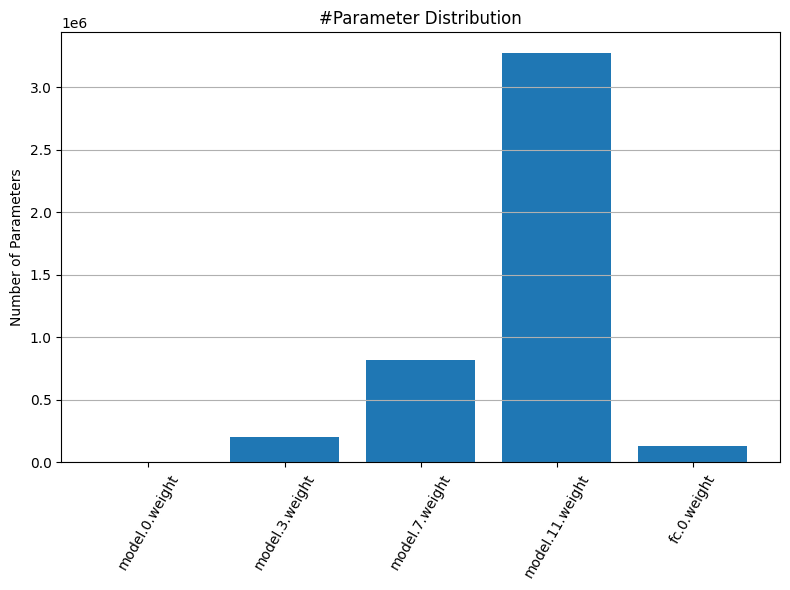

In [28]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(discriminator)

In [29]:
import matplotlib.pyplot as plt

def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))  
    axes = axes.ravel()
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:  # Анализируем только многомерные параметры (веса слоев)
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('Density')
            plot_index += 1

            if plot_index >= len(axes):  # Прекращаем, если слоев больше, чем ячеек
                break

    fig.suptitle('Histogram of Weights', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()


plot_weight_distribution(discriminator)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79aa1559b880> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

определения влияния разреженности слоев модели на точность

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Функция для применения разреженности к отдельному слою
@torch.no_grad()
def fine_grained_prune(param, sparsity):
    """
    Применяет разреженность (прунинг) к параметру слоя.
    """
    num_params = param.numel()
    num_zero = int(num_params * sparsity)  # Количество обнуляемых весов

    # Определяем пороговое значение для обнуления
    threshold = torch.topk(param.abs().view(-1), num_zero, largest=False).values.max()

    # Создаем маску и применяем разрежение
    mask = (param.abs() > threshold).float()
    param.mul_(mask)  # Применяем маску in-place
    return mask

# Функция оценки точности
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Evaluating Model", leave=False):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# Анализ влияния разреженности на точность
@torch.no_grad()
def sensitivity_analysis(model, dataloader, sparsity_values):
    """
    Проводит анализ влияния разреженности слоев модели на точность.
    """
    # Сохраняем исходное состояние параметров
    original_state = {name: param.clone() for name, param in model.named_parameters() if param.dim() > 1}

    sensitivity_results = {}
    for name, param in tqdm(model.named_parameters(), desc="Analyzing Layers"):
        if param.dim() > 1:  # Только для весов с размерностью больше 1
            accuracies = []
            for sparsity in sparsity_values:
                # Разрежаем слой
                print(f"Pruning {name} with sparsity {sparsity}...")
                fine_grained_prune(param, sparsity)
                # Оцениваем точность
                accuracy = evaluate_model(model, dataloader)
                accuracies.append(accuracy)
                print(f"Accuracy after pruning {name} at sparsity {sparsity}: {accuracy:.4f}")
                # Восстанавливаем параметры слоя
                param.data.copy_(original_state[name])

            sensitivity_results[name] = accuracies
            print(f"Layer {name} analysis completed.")
    return sensitivity_results

# Настройки анализа
sparsity_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Уровни разреженности
# Уменьшение объема данных для теста
small_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Запуск анализа
sensitivity_results = sensitivity_analysis(discriminator, small_val_loader, sparsity_values)

# Визуализация результатов
import matplotlib.pyplot as plt

for layer_name, accuracies in sensitivity_results.items():
    plt.plot(sparsity_values, accuracies, label=layer_name)

plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.title("Sensitivity Analysis: Layer Sparsity vs Accuracy")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score

# Функция для применения разреженности к отдельному слою
@torch.no_grad()
def fine_grained_prune(param, sparsity):
    """
    Применяет разреженность (прунинг) к параметру слоя.
    """
    num_params = param.numel()
    num_zero = int(num_params * sparsity)  # Количество обнуляемых весов

    # Определяем пороговое значение для обнуления
    threshold = torch.topk(param.abs().view(-1), num_zero, largest=False).values.max()

    # Создаем маску и применяем разрежение
    mask = (param.abs() > threshold).float()
    param.mul_(mask)  # Применяем маску in-place
    return mask

# Функция оценки F1-метрики
def evaluate_model_f1(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Evaluating Model", leave=False):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds)

# Анализ влияния разреженности на F1
@torch.no_grad()
def sensitivity_analysis_f1(model, dataloader, sparsity_values):
    """
    Проводит анализ влияния разреженности слоев модели на F1-метрику.
    """
    # Сохраняем исходное состояние параметров
    original_state = {name: param.clone() for name, param in model.named_parameters() if param.dim() > 1}

    sensitivity_results = {}
    for name, param in tqdm(model.named_parameters(), desc="Analyzing Layers"):
        if param.dim() > 1:  # Только для весов с размерностью больше 1
            f1_scores = []
            for sparsity in sparsity_values:
                # Разрежаем слой
                print(f"Pruning {name} with sparsity {sparsity}...")
                fine_grained_prune(param, sparsity)
                # Оцениваем F1
                f1 = evaluate_model_f1(model, dataloader)
                f1_scores.append(f1)
                print(f"F1 Score after pruning {name} at sparsity {sparsity}: {f1:.4f}")
                # Восстанавливаем параметры слоя
                param.data.copy_(original_state[name])

            sensitivity_results[name] = f1_scores
            print(f"Layer {name} analysis completed.")
    return sensitivity_results

# Настройки анализа
sparsity_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Уровни разреженности
# Уменьшение объема данных для теста
small_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Запуск анализа
sensitivity_results_f1 = sensitivity_analysis_f1(discriminator, small_val_loader, sparsity_values)

# Визуализация результатов
import matplotlib.pyplot as plt

for layer_name, f1_scores in sensitivity_results_f1.items():
    plt.plot(sparsity_values, f1_scores, label=layer_name)

plt.xlabel("Sparsity")
plt.ylabel("F1 Score")
plt.title("Sensitivity Analysis: Layer Sparsity vs F1 Score")
plt.legend()
plt.grid()
plt.show()


### EER

In [31]:
import torch
from tqdm import tqdm
from sklearn.metrics import roc_curve

# Функция для применения разреженности к отдельному слою
@torch.no_grad()
def fine_grained_prune(param, sparsity):
    """
    Применяет разреженность (прунинг) к параметру слоя.
    """
    num_params = param.numel()
    num_zero = int(num_params * sparsity)  # Количество обнуляемых весов

    # Определяем пороговое значение для обнуления
    threshold = torch.topk(param.abs().view(-1), num_zero, largest=False).values.max()

    # Создаем маску и применяем разрежение
    mask = (param.abs() > threshold).float()
    param.mul_(mask)  # Применяем маску in-place
    return mask

# Функция вычисления EER
def calculate_eer(y_true, y_pred):
    """
    Вычисляет Equal Error Rate (EER).
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer

# Функция оценки EER
def evaluate_model_eer(model, dataloader):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Evaluating Model", leave=False):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            all_scores.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy())
    return calculate_eer(all_labels, all_scores)

# Анализ влияния разреженности на EER
@torch.no_grad()
def sensitivity_analysis_eer(model, dataloader, sparsity_values):
    """
    Проводит анализ влияния разреженности слоев модели на EER.
    """
    # Сохраняем исходное состояние параметров
    original_state = {name: param.clone() for name, param in model.named_parameters() if param.dim() > 1}

    sensitivity_results = {}
    for name, param in tqdm(model.named_parameters(), desc="Analyzing Layers"):
        if param.dim() > 1:  # Только для весов с размерностью больше 1
            eers = []
            for sparsity in sparsity_values:
                # Разрежаем слой
                print(f"Pruning {name} with sparsity {sparsity}...")
                fine_grained_prune(param, sparsity)
                # Оцениваем EER
                eer = evaluate_model_eer(model, dataloader)
                eers.append(eer)
                print(f"EER after pruning {name} at sparsity {sparsity}: {eer:.4f}")
                # Восстанавливаем параметры слоя
                param.data.copy_(original_state[name])

            sensitivity_results[name] = eers
            print(f"Layer {name} analysis completed.")
    return sensitivity_results

# Настройки анализа
sparsity_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Уровни разреженности
# Уменьшение объема данных для теста
small_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Запуск анализа
sensitivity_results_eer = sensitivity_analysis_eer(discriminator, small_val_loader, sparsity_values)

# Визуализация результатов
import matplotlib.pyplot as plt

for layer_name, eers in sensitivity_results_eer.items():
    plt.plot(sparsity_values, eers, label=layer_name)

plt.xlabel("Sparsity")
plt.ylabel("EER")
plt.title("Sensitivity Analysis: Layer Sparsity vs EER")
plt.legend()
plt.grid()
plt.show()


Analyzing Layers: 0it [00:00, ?it/s]

Pruning model.0.weight with sparsity 0.1...



Evaluating Model:   3%|▎         | 50/1553 [00:07<04:32,  5.52it/s]
Analyzing Layers: 0it [00:07, ?it/s]                               


KeyboardInterrupt: 

### ПРИМЕНЯЕМ ПРУНИНГ И СОХРАНЯЕМ МОДЕЛЬ!

In [ ]:
import torch

# Функция для применения разреженности (прунинга)
@torch.no_grad()
def apply_pruning(model, sparsity_dict):
    """
    Применяет прунинг к модели на основе заданного словаря разреженности.
    """
    for name, param in model.named_parameters():
        if name in sparsity_dict and param.dim() > 1:
            # Применяем fine-grained разреженность к указанному слою
            fine_grained_prune(param, sparsity_dict[name])

# Функция для сохранения модели после прунинга
def save_pruned_model(model, save_path):
    """
    Сохраняет веса модели после прунинга.
    """
    torch.save(model.state_dict(), save_path)
    print(f"Pruned model saved to {save_path}")

# Пример задания разреженности для каждого слоя модели
sparsity_dict = {
    'model.0.weight': 0.05,  # 20% разреженность
    'model.3.weight': 0.05,  # 30% разреженность
    'model.7.weight': 0.5,  # 50% разреженность
    'model.11.weight': 0.1, # 10% разреженность
    'fc.0.weight': 0.7      # 70% разреженность 
}

# Применяем разреженность к модели
apply_pruning(discriminator, sparsity_dict)

# Сохраняем веса модели после прунинга
save_path = "pruned_discriminator.pth"
save_pruned_model(discriminator, save_path)


In [32]:
import torch

# Функция для подсчета параметров модели
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters() if p.dim() > 1)
    nonzero_params = total_params - zero_params
    return total_params, zero_params, nonzero_params

# Функция для применения разреженности (прунинга)
@torch.no_grad()
def apply_pruning(model, sparsity_dict):
    """
    Применяет прунинг к модели на основе заданного словаря разреженности.
    """
    for name, param in model.named_parameters():
        if name in sparsity_dict and param.dim() > 1:
            # Применяем fine-grained разреженность к указанному слою
            fine_grained_prune(param, sparsity_dict[name])

# Функция для сохранения модели после прунинга
def save_pruned_model(model, save_path):
    """
    Сохраняет веса модели после прунинга.
    """
    torch.save(model.state_dict(), save_path)
    print(f"Pruned model saved to {save_path}")

# Пример задания разреженности для каждого слоя модели
sparsity_dict = {
    'model.0.weight': 0.05,  # 20% разреженность
    'model.3.weight': 0.05,  # 30% разреженность
    'model.7.weight': 0.5,  # 50% разреженность
    'model.11.weight': 0.3, # 10% разреженность
    'fc.0.weight': 0.7      # 70% разреженность 
}

# Подсчет параметров до прунинга
total_params_before, zero_params_before, nonzero_params_before = count_parameters(discriminator)
print(f"Before pruning: Total parameters = {total_params_before}, Nonzero = {nonzero_params_before}, Zero = {zero_params_before}")

# Применяем разреженность к модели
apply_pruning(discriminator, sparsity_dict)

# Подсчет параметров после прунинга
total_params_after, zero_params_after, nonzero_params_after = count_parameters(discriminator)
print(f"After pruning: Total parameters = {total_params_after}, Nonzero = {nonzero_params_after}, Zero = {zero_params_after}")

# Степень разреженности модели
sparsity_ratio = zero_params_after / total_params_after * 100
print(f"Model sparsity: {sparsity_ratio:.2f}%")

# Сохраняем веса модели после прунинга
save_path = "pruned_discriminator3.pth"
save_pruned_model(discriminator, save_path)


Before pruning: Total parameters = 4434177, Nonzero = 4434017, Zero = 160
After pruning: Total parameters = 4434177, Nonzero = 2940821, Zero = 1493356
Model sparsity: 33.68%
Pruned model saved to pruned_discriminator3.pth


In [ ]:
from IPython.display import FileLink

# Путь
save_path = "/kaggle/working/pruned_discriminator.pth"


display(FileLink("pruned_discriminator.pth"))
